<a href="https://colab.research.google.com/github/mertaliclk/GenderDetectionModel/blob/main/GenderClassificationModel_mertali.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gender Classification Model Development

## **Mount to drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Imports**

**Imports**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

from IPython.display import display

**To decrease the ram usage**

In [ ]:
pd.set_option('display.max_colwidth',100)

**Extract the zip data**

In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/archive.zip', 'r')
zip_ref.extractall('/content/data')  # Extract to a new folder named 'data'
zip_ref.close()

## **Load the data**

**Load the data**

In [ ]:
# Image properties
image_height = 200
image_width = 200
channels = 3  # Assuming RGB channels

# Empty array for image data
image_data = np.empty((len(os.listdir('/content/data/crop_part1/')[0:1000]), image_height, image_width, channels))

# Lists to store ages and genders
ages = []
genders = []

# Loop through the first 1000 filenames (adjust the limit as needed)
under4_count = 0
for i, filename in enumerate(os.listdir('/content/data/crop_part1/')[0:1000]):
    # Extract age and gender from filename
    split = filename.split('_')
    ages.append(int(split[0]))
    genders.append(int(split[1]))

    # Load and preprocess image
    image = Image.open('/content/data/crop_part1/' + filename)
    image_data[i] = np.asarray(image)

In [ ]:
# Save data to .npz file
np.savez_compressed('gender_classification_data.npz', images=image_data, ages=ages, genders=genders)

In [ ]:
import numpy as np

# Load data from the .npz file
data = np.load('gender_classification_data.npz')

# Access loaded data
loaded_images = data['images']
loaded_ages = data['ages']
loaded_genders = data['genders']

In [ ]:
from tensorflow.keras.utils import to_categorical
y_classes = to_categorical(loaded_genders, num_classes=2)
print(loaded_genders.shape)
print(y_classes.shape)

(2000, 1)
(2000, 2)


In [ ]:
print(loaded_genders.shape)

(2000, 1)


**Dataset tests**

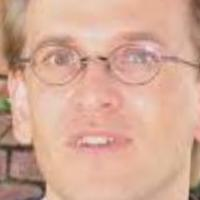

39 0


In [ ]:
# Assuming you want to display the first image (index 0)
image_data_scaled = (image_data[0]).astype(np.uint8)  # Scale and convert to uint8
image = Image.fromarray(image_data_scaled)
display(image)  # Used PIL's show method to display the image
print(ages[0], genders[0]) #accessed first elements from the lists

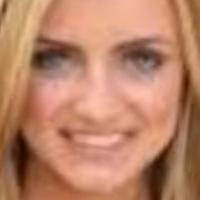

19 1


In [ ]:
# Assuming you want to display the second image (index 1)
image_data_scaled = (image_data[1]).astype(np.uint8)  # Scale and convert to uint8
image = Image.fromarray(image_data_scaled)
display(image)  # Used PIL's show method to display the image
print(ages[1], genders[1]) #accessed first elements from the lists

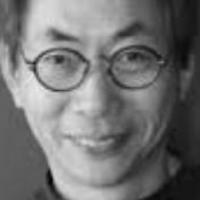

39 0


In [ ]:
# Assuming you want to display the third image (index 2)
image_data_scaled = (image_data[2]).astype(np.uint8)  # Scale and convert to uint8
image = Image.fromarray(image_data_scaled)
display(image)  # Used PIL's show method to display the image
print(ages[0], genders[0]) #accessed first elements from the lists

So we can say that, 0 corresponds to Male, 1 corresponds to Female.


##**Visualisation of data with plots**

**Plots for dataset simplification**

In [ ]:
# plot using df
# sns.set_theme()
# sns.distplot(df['Ages'],kde=True, bins=30)

<Figure size 800x500 with 0 Axes>

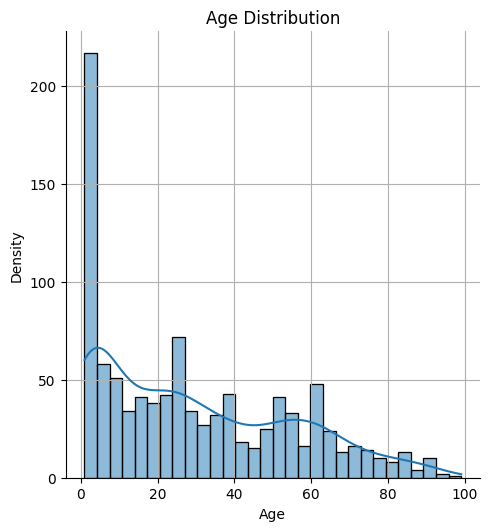

In [ ]:
# Create a distribution plot using matplotlib.pyplot
plt.figure(figsize=(8, 5))  # Adjust figure size as needed
sns.displot(ages, kde=True, bins=30)  # Use sns.distplot from seaborn within plt
plt.xlabel('Age')
plt.ylabel('Density')
plt.title('Age Distribution')
plt.grid(True)
plt.show()

There are many faces of children from 0 to 4 years old. The model won't need to try to fit for these ages and it could give its potential to other ages with higher performance.

In [ ]:
# Select indices where age is greater than 4
valids = loaded_ages > 4

# Select all data (images, ages, genders) corresponding to valid indices
selected_images = loaded_images[valids]
selected_ages = loaded_ages[valids]
selected_genders = loaded_genders[valids]

# Select data under 4 years old
under_4_images = loaded_images[~valids]
under_4_ages = loaded_ages[~valids]
under_4_genders = loaded_genders[~valids]

# Sample 30% of data under 4 years old (using random.sample for efficiency)
import random
num_under_4_to_sample = int(0.3 * len(under_4_images))  # Calculate number of samples
su_4_indices = random.sample(range(len(under_4_images)), num_under_4_to_sample)

su_4_images = under_4_images[su_4_indices]
su_4_ages = under_4_ages[su_4_indices]
su_4_genders = under_4_genders[su_4_indices]

# Combine data above 4 and sampled data under 4
combined_images = np.concatenate((selected_images, su_4_images))
combined_ages = np.concatenate((selected_ages, su_4_ages))
combined_genders = np.concatenate((selected_genders, su_4_genders))

# Filter original array based on valid_indices (more efficient than using DataFrame)
filtered_original_images = loaded_images[valids]
filtered_original_ages = loaded_ages[valids]
filtered_original_genders = loaded_genders[valids]

In here, when frac(frac=0.3) is equal to %30 percent of the samples under 4 years old; which means childrens who are under 4 years old will be randomly selected from %30 percent chance in order to filter original data set.

<Figure size 800x500 with 0 Axes>

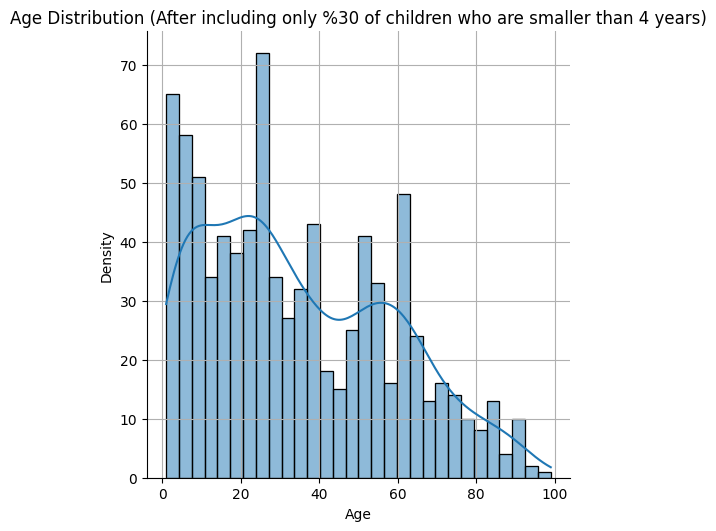

In [ ]:
# Create a distribution plot using matplotlib.pyplot
plt.figure(figsize=(8, 5))  # Adjust figure size as needed
sns.displot(combined_ages, kde=True, bins=30)
plt.xlabel('Age')
plt.ylabel('Density')
plt.title('Age Distribution (After including only %30 of children who are smaller than 4 years)')
plt.grid(True)
plt.show()

Also, there aren't many images of people over 80, so we can remove people over 80 to increase the performance of the model.

In [ ]:
# Select indices where age is between 4 and 80 (inclusive)
valids = (loaded_ages >= 4) & (loaded_ages <= 80)

# Select all data corresponding to valid indices
filtered_images = loaded_images[valids]
filtered_ages = loaded_ages[valids]
filtered_genders = loaded_genders[valids]

# Combine data between 4-80 and sampled data under 4
new_combined_images = np.concatenate((filtered_images, su_4_images))
new_combined_ages = np.concatenate((filtered_ages, su_4_ages))
new_combined_genders = np.concatenate((filtered_genders, su_4_genders))

In [ ]:
# Create a distribution plot using seaborn.distplot
plt.figure(figsize=(8, 5))  # Adjust figure size as needed
sns.displot(new_combined_ages, kde=True, bins=20)  # Use filtered_ages after filtering

# Customize the plot (similar to your previous code)
plt.xlabel('Age')
plt.ylabel('Density')
plt.title('Age Distribution (Filtered)')
plt.grid(True)
plt.show()

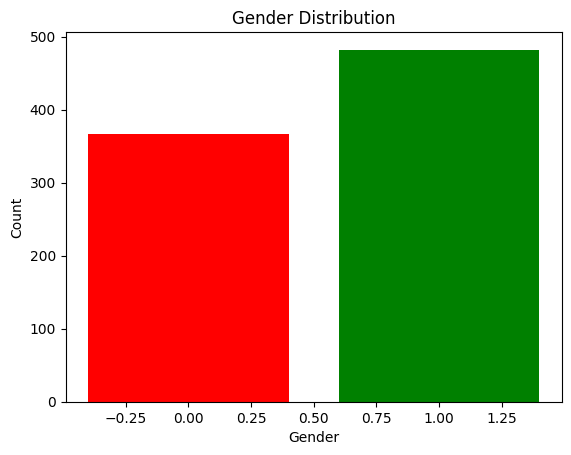

In [ ]:
# Assuming your genders data is in a NumPy array named genders
genders = combined_genders  # Replace with your actual genders data

unique_genders, counts = np.unique(genders, return_counts=True)

colors = ['red', 'green']
plt.bar(unique_genders, counts, color=colors)
plt.xlabel("Gender")
plt.ylabel("Count")
plt.title("Gender Distribution")
plt.show()


In [ ]:
df = df[df['Genders'] != 3]

3 corresponds to a gender but there is no such gender clarification in this program, because of that we can remove it too.

In [ ]:
# Assuming you've loaded 'genders' from your .npz file
genders_data = np.load('gender_classification_data.npz')['genders']

# Filter indices for genders NOT equal to 3 (assuming 3 represents a specific gender to exclude)
filtered_indices = np.where(genders_data != 3)[0]

# Filter image, age, and gender data based on the filtered indices
filtered_images = image_data[filtered_indices]
filtered_ages = ages_data[filtered_indices]
filtered_genders = genders_data[filtered_indices]


**Resize arrays**

In [ ]:
from skimage.transform import resize

x = []
y = []

# Loop through each image, age, and gender in the combined arrays
for i in range(len(combined_images)):
  # Reshape the image if necessary
  if len(combined_images[i].shape) == 3:
    image = combined_images[i].reshape((combined_images[i].shape[0], combined_images[i].shape[1], 3))  # Reshape for RGB if needed
  else:
    image = combined_images[i]  # No reshape needed

  # Resize the image using scikit-image.transform.resize
  resized_image = resize(image, (128, 128), anti_aliasing=True, mode='reflect')  # Specify anti-aliasing and mode

  # Convert the resized image to a NumPy array (already an array)
  ar = resized_image

  # Append the image array to the x list
  x.append(ar)

  # Combine age and gender into a single list
  age_gender = [combined_ages[i], combined_genders[i]]

  # Append the age-gender list to the y list
  y.append(age_gender)

# Convert the lists to NumPy arrays
x = np.array(x)
y = np.array(y)


**Test plots**

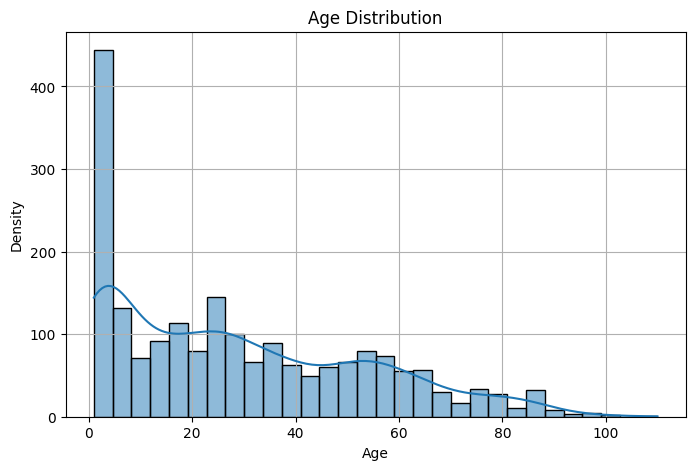

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))  # Create figure and axes
sns.histplot(ages, kde=True, bins=30, ax=ax)  # Specify axes for plot

# Customize plot (applicable to both options)
plt.xlabel('Age')
plt.ylabel('Density')
plt.title('Age Distribution')
plt.grid(True)
plt.show()

In [ ]:
sns.histplot(df['Ages'],kde=True, bins=30)

In [ ]:
sns.histplot(df['Ages'],kde=True, stat="density")

In [ ]:
sns.histplot(
    df["Ages"], kde=True,
    stat="density", kde_kws=dict(cut=3),
    alpha=.4, edgecolor=(1, 1, 1, .4),
)

In [ ]:
sns.displot(df["Ages"], kind="kde")

## **Split data into training and testing sets**

In [ ]:
# Split data into training and testing sets (20% for testing)
x_train_age, x_test_age, y_train_age, y_test_age = train_test_split(x, y, test_size=0.2)
x_train_gender, x_test_gender, y_train_gender, y_test_gender = train_test_split(x, y, test_size=0.2)

# Training and testing sets for both age and gender data
print("Training data shapes:")
print(f"x_train_age: {x_train_age.shape}")
print(f"y_train_age: {y_train_age.shape}")
print(f"x_train_gender: {x_train_gender.shape}")
print(f"y_train_gender: {y_train_gender.shape}")

print("\nTesting data shapes:")
print(f"x_test_age: {x_test_age.shape}")
print(f"y_test_age: {y_test_age.shape}")
print(f"x_test_gender: {x_test_gender.shape}")
print(f"y_test_gender: {y_test_gender.shape}")

Training data shapes:
x_train_age: (678, 128, 128, 3)
y_train_age: (678, 2)
x_train_gender: (678, 128, 128, 3)
y_train_gender: (678, 2)

Testing data shapes:
x_test_age: (170, 128, 128, 3)
y_test_age: (170, 2)
x_test_gender: (170, 128, 128, 3)
y_test_gender: (170, 2)


## **Model Creation**

**Predict Gender**

In [ ]:
import numpy as np

image_height, image_width, channels = resized_image.shape

print("Image dimensions:", image_height, "x", image_width, "x", channels)

Image dimensions: 128 x 128 x 3


In [ ]:
genmodel = Sequential()
genmodel.add(Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)))
genmodel.add(Conv2D(64, (3,3), activation='relu'))
genmodel.add(MaxPooling2D((2,2)))
genmodel.add(Conv2D(64, (3,3), activation='relu'))
genmodel.add(Conv2D(64, (3,3), activation='relu'))
genmodel.add(MaxPooling2D((2,2)))
genmodel.add(Conv2D(128, (3,3),strides=(2,2), activation='relu'))
genmodel.add(Conv2D(128, (3,3), activation='relu'))
genmodel.add(MaxPooling2D((2,2)))
genmodel.add(Flatten())
genmodel.add(Dense(64, activation='relu'))
genmodel.add(Dropout(0.5))
genmodel.add(Dense(1, activation='sigmoid'))

genmodel.compile(loss='binary_crossentropy',
             optimizer=optimizers.Adam(lr=0.0001),
             metrics=['accuracy'])
genmodel.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 conv2d_4 (Conv2D)           (None, 124, 124, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 conv2d_6 (Conv2D)           (None, 58, 58, 64)        36928     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 29, 29, 64)        0         
 g2D)                                                 

**Predict Age**

In [ ]:
agemodel = Sequential()
agemodel.add(Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)))
agemodel.add(MaxPooling2D((2,2)))
agemodel.add(Conv2D(64, (3,3), activation='relu'))
agemodel.add(MaxPooling2D((2,2)))
agemodel.add(Conv2D(128, (3,3), activation='relu'))
agemodel.add(MaxPooling2D((2,2)))
agemodel.add(Flatten())
agemodel.add(Dense(64, activation='relu'))
agemodel.add(Dropout(0.5))
agemodel.add(Dense(1, activation='relu'))

agemodel.compile(loss='mean_squared_error',
             optimizer=optimizers.Adam(lr=0.0001))
agemodel.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 128)       0

## **Training the model**

**Train Gender**

In [ ]:
datagen = ImageDataGenerator(
    rescale=1./255.,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255.)

train_generator = datagen.flow(x=combined_images, y=combined_genders, batch_size=16, shuffle=True)
test_generator = test_datagen.flow(x=combined_images, y=combined_genders, batch_size=64, shuffle=False)

history2 = genmodel.fit(train_generator, epochs=5, validation_data=test_generator)


Epoch 1/5


InvalidArgumentError: Graph execution error:

Detected at node sequential_1/dense_2/Relu defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-26-47b8a7efcb50>", line 13, in <cell line: 13>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1807, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 590, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/sequential.py", line 398, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 515, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py", line 255, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/activations.py", line 306, in relu

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend.py", line 5395, in relu

Matrix size-incompatible: In[0]: [16,12800], In[1]: [4608,64]
	 [[{{node sequential_1/dense_2/Relu}}]] [Op:__inference_train_function_2446]

numpy array olarak train et.

**Train Age**

In [ ]:
datagen = ImageDataGenerator(rescale=1./255.)

test_datagen = ImageDataGenerator(rescale=1./255.)

train_image_generator = datagen.flow(x=combined_images, batch_size=16, shuffle=True)
train_age_generator = train_image_generator.flow(y=combined_ages)

test_image_generator = test_datagen.flow(x=combined_images, batch_size=32, shuffle=False)
test_age_generator = test_image_generator.flow(y=combined_ages)


history1 = agemodel.fit(
    x=[train_image_generator],
    y=train_age_generator,
    epochs=5,
    validation_data=(test_image_generator, test_age_generator)
)


numpy divide fonksiyonu


## **Evaluating the model**

In [ ]:
def process_and_predict(file):
    im = Image.open(file)
    width, height = im.size
    if width == height:
        im = im.resize((128,128), Image.ANTIALIAS)
    else:
        if width > height:
            left = width/2 - height/2
            right = width/2 + height/2
            top = 0
            bottom = height
            im = im.crop((left,top,right,bottom))
            im = im.resize((128,128), Image.ANTIALIAS)
        else:
            left = 0
            right = width
            top = 0
            bottom = width
            im = im.crop((left,top,right,bottom))
            im = im.resize((128,128), Image.ANTIALIAS)

    ar = np.asarray(im)
    ar = ar.astype('float32')
    ar /= 255.0
    ar = ar.reshape(-1, 200, 200, 3)

    age = agemodel.predict(ar)
    gender = np.round(genmodel.predict(ar))
    if gender == 0:
        gender = 'male'
    elif gender == 1:
        gender = 'female'

    print('Age:', int(age), '\n Gender:', gender)
    return im.resize((300,300), Image.ANTIALIAS)

In [ ]:
process_and_predict('/content/__results___34_1.png')

FileNotFoundError: [Errno 2] No such file or directory: '/content/__results___34_1.png'